## Data Preprocessing and Model Training

In [17]:
# General Libraries:
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split

# Libraries for Data Vizualization:
import matplotlib.pyplot as plt

### Data Loading and Cleaning

In [5]:
def load_data(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, label)):
            img_path = os.path.join(directory, label, image)

            # Read and resize the image using Pillow
            img = Image.open(img_path)
            img_array = np.array(img)

            # Append the image array and the label to the lists
            images.append(img_array)
            labels.append(label)

    # Shuffle the arrays using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=42)

    return images, labels

In [6]:
train_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Training'
test_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Testing'

# Load training data
train_images, train_labels = load_data(train_dir)

# Load testing data
test_images, test_labels = load_data(test_dir)

In [7]:
# Check data structure

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print("Number of Images in Train Set:", num_train_images)
print("Number of Labels in Train Set:", num_train_labels)
print("Number of Images in Test Set:", num_test_images)
print("Number of Labels in Test Set:", num_test_labels)

Number of Images in Train Set: 5712
Number of Labels in Train Set: 5712
Number of Images in Test Set: 1311
Number of Labels in Test Set: 1311


In [12]:
def remove_duplicates(images, labels):
    unique_pairs = set()
    unique_images = []
    unique_labels = []
    num_removed = 0

    for img, label in zip(images, labels):
        img_str = img.tobytes()
        pair = (img_str, label)

        # Check if the pair is unique
        if pair not in unique_pairs:
            unique_pairs.add(pair)
            unique_images.append(img)
            unique_labels.append(label)
        else:
            num_removed += 1

    print(f"Removed {num_removed} duplicate images.")
    
    return shuffle(unique_images, unique_labels, random_state=99)

In [13]:
# Remove duplicates from training data
train_images, train_labels = remove_duplicates(train_images, train_labels)

# Remove duplicates from testing data
test_images, test_labels = remove_duplicates(test_images, test_labels)

<ipython-input-12-632cbc8c3244>:8: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_str = img.tostring()


Removed 0 duplicate images.
Removed 0 duplicate images.


In [15]:
def print_class_distribution(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass Distribution in {dataset_name} Dataset:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} images")
    
    total_images = len(labels)
    print(f"Total number of images in {dataset_name} Dataset: {total_images}")

# Print training data class distribution
print_class_distribution(train_labels, 'Training')

# Print testing data class distribution
print_class_distribution(test_labels, 'Testing')



Class Distribution in Training Dataset:
Class glioma: 1321 images
Class meningioma: 1333 images
Class notumor: 1406 images
Class pituitary: 1445 images
Total number of images in Training Dataset: 5505

Class Distribution in Testing Dataset:
Class glioma: 299 images
Class meningioma: 301 images
Class notumor: 381 images
Class pituitary: 300 images
Total number of images in Testing Dataset: 1281


### Data Preprocessing

In [18]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [31]:
def preprocess_images(images, desired_size=(128, 128)):
    preprocessed_images = []

    for img_array in images:
        # Convert numpy array to Pillow Image
        img = Image.fromarray(img_array)

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)

        # Convert the image back to a numpy array
        img_array = np.array(img)

        preprocessed_images.append(img_array)

    return preprocessed_images

In [41]:
# Specify your desired width and height for resizing
your_desired_width = 500
your_desired_height = 550

train_images_processed = preprocess_images(train_images)
val_images_processed = preprocess_images(val_images)
test_images_processed = preprocess_images(test_images)

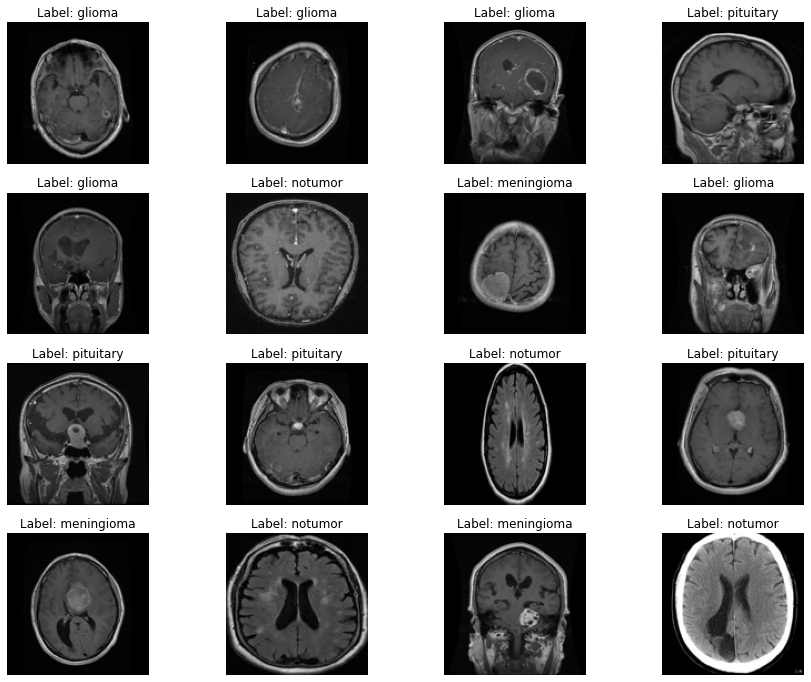

In [43]:
import matplotlib.pyplot as plt

# Function to display a grid of images
def display_images(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(images[index])
            axes[i, j].set_title(f"Label: {labels[index]}")
            axes[i, j].axis('off')

    plt.show()

# Display some preprocessed training images
display_images(train_images_processed, train_labels, rows=4, cols=4)